In [1]:
!pip install transformers==3

In [2]:
!pip install torchcsprng==0.1.3+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install opacus

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from tqdm import tqdm


# Use GPU
device = torch.device("cuda")

In [4]:
VIRTUAL_BATCH_SIZE = 32

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/My Drive/dep1_cleaned.csv")
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


In [7]:
# Displaying Class distribution
df['target'].value_counts(normalize = True)

0    0.728036
1    0.271964
Name: target, dtype: float64

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['target'])

# Using temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.1, 
                                                                stratify=temp_labels)

In [9]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [10]:
# Sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# Encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


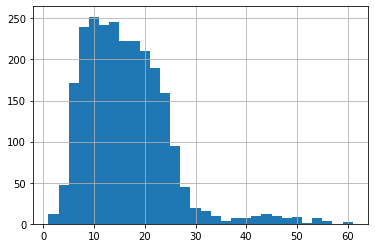

In [11]:
# Getting length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [12]:
max_seq_len = 25
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [13]:
# Converting Integer Sequences to Tensor

# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from opacus.utils.uniform_sampler import UniformWithReplacementSampler


# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

BATCH_SIZE = 8
SAMPLE_RATE = BATCH_SIZE / len(train_data)
assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

train_sampler = UniformWithReplacementSampler(
    num_samples=len(train_data),
    sample_rate=SAMPLE_RATE,
)


# Sampler for sampling the data during training
# train_sampler = RandomSampler(train_data)

# DataLoader for train set
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
train_dataloader = DataLoader(train_data, batch_sampler=train_sampler)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=BATCH_SIZE)


In [15]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [16]:
# Model Architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # Softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)
      
      # Apply softmax activation
      x = self.softmax(x)

      return x

In [17]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push the model to GPU
model = model.to(device)

In [18]:
# Optimizer from hugging face transformers
from transformers import AdamW

# Define the optimizer
#optimizer = AdamW(model.parameters(), lr = 1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)


#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.001)

In [19]:
# Finding class weights

from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.68663339 1.83952452]


In [20]:
# Convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

print(weights)

# Loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# Number of training epochs
# epochs = 10

EPOCHS = 2
LOGGING_INTERVAL = 50 # once every how many steps we run evaluation cycle and report metrics
EPSILON = 7.5
DELTA = 1 / len(train_dataloader)

tensor([0.6866, 1.8395], device='cuda:0')


In [21]:
from opacus import PrivacyEngine

MAX_GRAD_NORM = 0.1

privacy_engine = PrivacyEngine(
    module=model,
    sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
    target_delta = DELTA,
    target_epsilon = EPSILON, 
    epochs = EPOCHS,
    max_grad_norm=MAX_GRAD_NORM,
)
privacy_engine.attach(optimizer)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [22]:
'''
def clip_grad_norm(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

    return total_norm
'''

'\ndef clip_grad_norm(parameters, max_norm, norm_type=2):\n    parameters = list(filter(lambda p: p.grad is not None, parameters))\n    total_norm = 0\n    for p in parameters:\n        param_norm = p.grad.data.norm(norm_type)\n        total_norm += param_norm.item() ** norm_type\n\n    return total_norm\n'

In [23]:
# Function to train the model
'''
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save model predictions
  total_preds=[]

  
  # Iterate over batches
  for step, batch in enumerate(tqdm(train_dataloader)):
    print(batch.size())
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    # batch = [r.to(device) for r in batch]

    batch = tuple(t.to(device) for t in batch)
      
    sent_id, mask, labels = batch

    # Clear previously calculated gradients 
    model.zero_grad()

    print(mask.size())        

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    if (step + 1) % N_ACCUMULATION_STEPS == 0 or step == len(train_dataloader) - 1:
      optimizer.step()
    else:
      optimizer.virtual_step()
    
    if step > 0 and step % LOGGING_INTERVAL == 0:
      train_loss = np.mean(losses)
      eps, alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)

      eval_loss, eval_accuracy = evaluate()

      print(
          f"Epoch: {epoch} | "
          f"Step: {step} | "
          f"Train loss: {train_loss:.3f} | "
          f"Eval loss: {eval_loss:.3f} | "
          f"Eval accuracy: {eval_accuracy:.3f} | "
          f"ɛ: {eps:.2f} (α: {alpha})"
      )

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Append the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Predictions are in the form of (no. of batches, size of batch, no. of classes).
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Returns the loss and predictions
  return avg_loss, total_preds
'''

'\ndef train():\n  \n  model.train()\n\n  total_loss, total_accuracy = 0, 0\n  \n  # Empty list to save model predictions\n  total_preds=[]\n\n  \n  # Iterate over batches\n  for step, batch in enumerate(tqdm(train_dataloader)):\n    print(batch.size())\n    \n    # Progress update after every 50 batches.\n    if step % 50 == 0 and not step == 0:\n      print(\'  Batch {:>5,}  of  {:>5,}.\'.format(step, len(train_dataloader)))\n\n    # Push the batch to gpu\n    # batch = [r.to(device) for r in batch]\n\n    batch = tuple(t.to(device) for t in batch)\n      \n    sent_id, mask, labels = batch\n\n    # Clear previously calculated gradients \n    model.zero_grad()\n\n    print(mask.size())        \n\n    # Get model predictions for the current batch\n    preds = model(sent_id, mask)\n\n    # Compute the loss between actual and predicted values\n    loss = cross_entropy(preds, labels)\n\n    # Add on to the total loss\n    total_loss = total_loss + loss.item()\n\n    if (step + 1) % N_ACC

In [24]:
# Function for evaluating the model
'''
def evaluate():
  
  print("\nEvaluating...")
  
  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save the model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    #if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # Deactivate autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      loss.backward()

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds
  '''

'\ndef evaluate():\n  \n  print("\nEvaluating...")\n  \n  # Deactivate dropout layers\n  model.eval()\n\n  total_loss, total_accuracy = 0, 0\n  \n  # Empty list to save the model predictions\n  total_preds = []\n\n  # Iterate over batches\n  for step,batch in enumerate(val_dataloader):\n    \n    # Progress update every 50 batches.\n    #if step % 50 == 0 and not step == 0:\n      \n      # Calculate elapsed time in minutes.\n      #elapsed = format_time(time.time() - t0)\n            \n      # Report progress.\n      #print(\'  Batch {:>5,}  of  {:>5,}.\'.format(step, len(val_dataloader)))\n\n    # Push the batch to gpu\n    batch = [t.to(device) for t in batch]\n\n    sent_id, mask, labels = batch\n\n    # Deactivate autograd\n    with torch.no_grad():\n      \n      # Model predictions\n      preds = model(sent_id, mask)\n\n      # Compute the validation loss between actual and predicted values\n      loss = cross_entropy(preds,labels)\n\n      loss.backward()\n\n      total_loss = 

In [25]:
import numpy as np
from tqdm.notebook import tqdm

def accuracy(preds, labels):
    return (preds == labels).mean()

# define evaluation cycle
def evaluate(model):    
    model.eval()

    loss_arr = []
    accuracy_arr = []
    
    for step,batch in enumerate(val_dataloader):
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'sent_id':      batch[0],
                      'mask':         batch[1],
                      'labels':       batch[2]}

            outputs = model(inputs['sent_id'], inputs['mask'])
            #loss, logits = outputs[:2]
            loss = cross_entropy(outputs, inputs['labels'])

            #loss.backward()

            preds = np.argmax(outputs.detach().cpu().numpy(), axis=1)        
            #preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = inputs['labels'].detach().cpu().numpy()
            
            loss_arr.append(loss.item())
            accuracy_arr.append(accuracy(preds, labels))
    
    model.train()
    return np.mean(loss_arr), np.mean(accuracy_arr)

In [26]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# For each epoch
for epoch in range(EPOCHS):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
    losses = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        
      batch = tuple(t.to(device) for t in batch)
      inputs = {'sent_id':  batch[0],
                'mask':     batch[1],
                'labels':   batch[2]}

      outputs = model(inputs['sent_id'], inputs['mask']) # output = loss, logits, hidden_states, attentions
      
      loss = cross_entropy(outputs, inputs['labels'])
      #total_loss = total_loss + loss.item()
      loss.backward()

      losses.append(loss.item())

      # We process small batches of size BATCH_SIZE, 
      # until they're accumulated to a batch of size VIRTUAL_BATCH_SIZE.
      # Only then we make a real `.step()` and update model weights
      if (step + 1) % N_ACCUMULATION_STEPS == 0 or step == len(train_dataloader) - 1:
          optimizer.step()
      else:
          optimizer.virtual_step()

      if step > 0 and step % LOGGING_INTERVAL == 0:
          train_loss = np.mean(losses)
          eps, alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)

          eval_loss, eval_accuracy = evaluate(model)

          print(
              f"Epoch: {epoch} | "
              f"Step: {step} | "
              f"Train loss: {train_loss:.3f} | "
              f"Eval loss: {eval_loss:.3f} | "
              f"Eval accuracy: {eval_accuracy:.3f} | "
              f"ɛ: {eps:.2f} (α: {alpha})"
          )
  
          # Save the best model
          if eval_loss < best_valid_loss:
            best_valid_loss = eval_loss
            torch.save(model.state_dict(), 'DPSGDBert_saved_weights.pt')
        
          # Append training and validation loss
          train_losses.append(train_loss)
          valid_losses.append(eval_loss)
        
    #print(f'\nTraining Loss: {train_loss:.3f}')
    #print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2


Epoch: 0 | Step: 50 | Train loss: 0.756 | Eval loss: 0.867 | Eval accuracy: 0.727 | ɛ: 4.20 (α: 2.6)
Epoch: 0 | Step: 100 | Train loss: 0.929 | Eval loss: 1.470 | Eval accuracy: 0.727 | ɛ: 4.75 (α: 2.5)
Epoch: 0 | Step: 150 | Train loss: 1.173 | Eval loss: 2.222 | Eval accuracy: 0.727 | ɛ: 5.11 (α: 2.4)
Epoch: 0 | Step: 200 | Train loss: 1.524 | Eval loss: 2.967 | Eval accuracy: 0.727 | ɛ: 5.46 (α: 2.3)
Epoch: 0 | Step: 250 | Train loss: 1.750 | Eval loss: 3.227 | Eval accuracy: 0.727 | ɛ: 5.71 (α: 2.3)
Epoch: 0 | Step: 300 | Train loss: 1.944 | Eval loss: 3.152 | Eval accuracy: 0.727 | ɛ: 5.98 (α: 2.3)


 Epoch 2 / 2


Epoch: 1 | Step: 50 | Train loss: 3.105 | Eval loss: 2.950 | Eval accuracy: 0.727 | ɛ: 6.26 (α: 2.2)
Epoch: 1 | Step: 100 | Train loss: 2.910 | Eval loss: 2.874 | Eval accuracy: 0.727 | ɛ: 6.47 (α: 2.2)
Epoch: 1 | Step: 150 | Train loss: 2.843 | Eval loss: 2.901 | Eval accuracy: 0.727 | ɛ: 6.67 (α: 2.2)
Epoch: 1 | Step: 200 | Train loss: 2.789 | Eval loss: 2.926 | Eval accuracy: 0.727 | ɛ: 6.89 (α: 2.2)
Epoch: 1 | Step: 250 | Train loss: 2.794 | Eval loss: 2.906 | Eval accuracy: 0.727 | ɛ: 7.07 (α: 2.1)
Epoch: 1 | Step: 300 | Train loss: 2.770 | Eval loss: 2.918 | Eval accuracy: 0.727 | ɛ: 7.24 (α: 2.1)



In [27]:
# Load weights of best model
model.load_state_dict(torch.load('DPSGDBert_saved_weights.pt'))

<All keys matched successfully>

In [28]:
# Get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [29]:
# Model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        45
           1       0.00      0.00      0.00        17

    accuracy                           0.73        62
   macro avg       0.36      0.50      0.42        62
weighted avg       0.53      0.73      0.61        62



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Confusion matrix
pd.crosstab(test_y, preds)

col_0,0
row_0,
0,45
1,17


In [31]:
print (type(test_y))

<class 'torch.Tensor'>


In [32]:
print (test_y)

tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])


In [33]:
testy_list = test_y.tolist()
print (testy_list)

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


In [34]:
preds_list = preds.tolist()
print (preds_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [35]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(testy_list, preds_list)

#Printing per class accuracy
print (100*matrix.diagonal()/matrix.sum(axis=1))


[100.   0.]
